# Tutorial 4: Convergence rates

## The problem

It is reasonably easy to check that $p=\mathrm{e}^{\mathrm{i}kx_0}$ is the solution of

$$
\Delta p + k^2p=0 \quad \text{in }\Omega,
$$
$$
\frac{\partial p}{\partial \mathbf{n}} = \mathrm{i}kn_0\mathrm{e}^{\mathrm{i}kx_0}\quad \text{on }\Gamma,
$$
where $\mathbf{x}=(x_0,x_1,x_2)$ is a point in $\Omega$ and $\textbf{n}=(n_0,n_1,n_2)$ is the normal to the surface $\Gamma$.

In this tutorial, we solve this problem using BEM and compare the approximate solution to this knows actual solution.

## BEM formulation

### Representation formula

$$
p = \mathcal{D}p-\mathcal{S}\frac{\partial p}{\partial \mathbf{n}}
$$

where $\mathcal{S}$ is the single layer potential operator and $\mathcal{D}$ is the double layer potential operator.

### Boundary integral equation

$$
(\mathsf{D}+\tfrac{1}{2}\mathsf{I})p=\mathsf{S}\frac{\partial p}{\partial \mathbf{n}},
$$

where $\mathsf{S}$ is the single layer boundary operator; $\mathsf{D}$ is the double layer boundary operator; and $\mathsf{I}$ is the identity operator.

### Solving with Bempp

We can solve this problem using the code below. In this example, we use a cuboid 1.5 units long, 1 unit wide, and 1 unit high: we import this mesh from the file `cuboid.msh`.

In [1]:
import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

k = 4.

grid = bempp.api.import_grid("cuboid.msh")

space = bempp.api.function_space(grid, "DP", 0)

identity = sparse.identity(space, space, space)
single_layer = helmholtz.single_layer(space, space, space, k)
double_layer = helmholtz.double_layer(space, space, space, k)

@bempp.api.complex_callable
def lambda_callable(x, n, domain_index, result):
    result[0] = 1j * k * np.exp(1j * k * x[0]) * n[0]

lambda_fun = bempp.api.GridFunction(space, fun=lambda_callable)

p_total, info = gmres(double_layer + 0.5 * identity, single_layer * lambda_fun, tol=1E-5)

We can now compare our solution to the solution we are expecting. To do this, we create a `GridFunction` representing the actual solution, and take the $L^2$ norm of the difference between our approximation and the actual solution.

0.4 isn't too big, so it looks like we've got a pretty good approximation.

In [2]:
@bempp.api.complex_callable
def actual_solution_f(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])

actual_solution = bempp.api.GridFunction(space, fun=actual_solution_f)

print((p_total - actual_solution).l2_norm())

0.41326500769117885


To get a better understanding of the accuracy of our BEM approximation, we can look at how the $L^2$ norm changes as we change the number of elements in our mesh.

The following code uses a for loop to calculate the error for a range of values of $h$. The $h$ parameter controls the size of each triangle.

In [3]:
import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

k = 4.

@bempp.api.complex_callable
def lambda_callable(x, n, domain_index, result):
    result[0] = 1j * k * np.exp(1j * k * x[0]) * n[0]

@bempp.api.complex_callable
def actual_solution_f(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])

h_values = []
errors = []
ndofs = []
for i in range(2, 10):
    h = 2 ** -(i/2)

    grid = bempp.api.shapes.cuboid(length=(1.5, 1, 1), h=h)
    space = bempp.api.function_space(grid, "DP", 0)

    identity = sparse.identity(space, space, space)
    single_layer = helmholtz.single_layer(space, space, space, k)
    double_layer = helmholtz.double_layer(space, space, space, k)

    lambda_fun = bempp.api.GridFunction(space, fun=lambda_callable)

    p_total, info = gmres(double_layer + 0.5 * identity, single_layer * lambda_fun, tol=1E-5)

    actual_solution = bempp.api.GridFunction(space, fun=actual_solution_f)
    
    h_values.append(h)
    ndofs.append(space.global_dof_count)
    errors.append((p_total - actual_solution).l2_norm())
    print(h, errors[-1])

0.5 0.7974278842777981
0.3535533905932738 0.4639766101213504
0.25 0.3615649671805228
0.1767766952966369 0.19117350563272814
0.125 0.11249838362456548
0.08838834764831845 0.05736033728592835
0.0625 0.03268628009237414
0.04419417382415922 0.01696026668525607


We can then make a convergence plot showing how the error decreases as we decrease $h$.

We have used some features of matplotlib to make this plot as informative as possible:

- We use `plt.xscale` and `plt.yscale` to plot $\log(h)$ against $\log(\text{error})$. The error will be approximately polynomial: plotting it on log-log axes will turn it into a straight line where the gradient is the polynomial order.
- We use `plt.axis` to make the axes equal aspect. The gradient is an important feature of the plot, and it is much easier to just the gradient on a equal aspect plot.
- We use `plt.xlim` to reverse the $h$-axis. This one is due to my own personal preference (and you may prefer otherwise), but I think it makes more sense for the number of elements to increase to the right (and so for $h$ to decrease to the right).

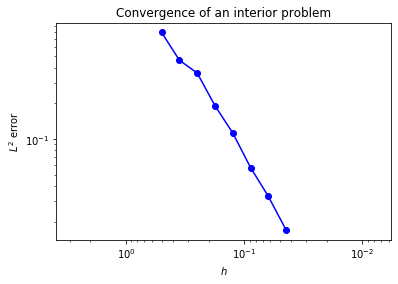

In [4]:
%matplotlib inline

plt.plot(h_values, errors, "bo-")
plt.xlabel("$h$")
plt.ylabel("$L^2$ error")
plt.xscale("log")
plt.yscale("log")
plt.axis("equal")
plt.xlim(plt.xlim()[::-1])

plt.title("Convergence of an interior problem")

plt.show()

Alternatively, we could plot the error against the number of degrees of freedom (DOFs). In the code above, we used `space.global_dof_count` to get these values and stored them in the list `ndofs`. This line has a different gradient to the plot above as the number of DOFs scales like $h^{-2}$.

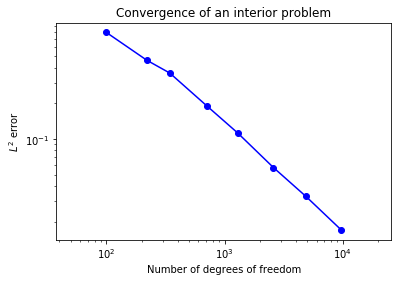

In [5]:
%matplotlib inline

plt.plot(ndofs, errors, "bo-")
plt.xlabel("Number of degrees of freedom")
plt.ylabel("$L^2$ error")
plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.title("Convergence of an interior problem")

plt.show()

In this final plot, we add a trend line to indicate order 1.5 convergence (ie $\text{error} = ch^{1.5}$).

We do this by plotting $ch^{1.5}$ for appropriate values of $h$ and a value of $c$ chosen to put the trend near our error line. As the trend line will be a straight line on a log-log plot, we only need to tell matplotlib the first and last coordinates on the line.

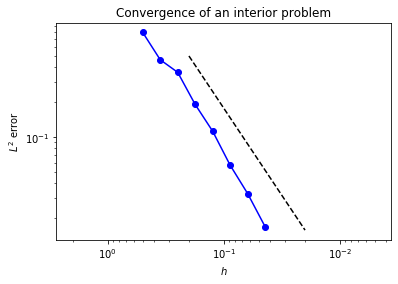

In [6]:
%matplotlib inline

plt.plot(h_values, errors, "bo-")
plt.plot([0.2, 0.02], [0.5, 0.5 * (0.02 / 0.2) ** 1.5], "k--")
plt.xlabel("$h$")
plt.ylabel("$L^2$ error")
plt.xscale("log")
plt.yscale("log")
plt.axis("equal")
plt.xlim(plt.xlim()[::-1])

plt.title("Convergence of an interior problem")

plt.show()

## What next?

After reading this tutorial, you should attempt [exercise 3](../exercises/3_iterations.ipynb).